In [1]:
## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
## 2. Load Dataset
df = pd.read_csv('/content/amazon_delivery.csv')
print("Shape of data:", df.shape)
df.head()

Shape of data: (43739, 16)


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


In [3]:
## 3. Data Preprocessing
# Drop rows with missing values
df.dropna(inplace=True)
df.shape

(43594, 16)

In [5]:
# 1. Combine datetime and calculate time to pickup
df['Order_DateTime'] = pd.to_datetime(df['Order_Date'] + ' ' + df['Order_Time'])
df['Pickup_DateTime'] = pd.to_datetime(df['Order_Date'] + ' ' + df['Pickup_Time'])
df['Time_To_Pickup'] = (df['Pickup_DateTime'] - df['Order_DateTime']).dt.total_seconds() / 60.0

# 2. Haversine Distance Calculation
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["Distance_km"] = haversine_distance(df["Store_Latitude"], df["Store_Longitude"],
                                       df["Drop_Latitude"], df["Drop_Longitude"])

# 3. Assign weight per category
category_weights = {
    "Clothing": 1.0,
    "Electronics": 2.0,
    "Sports": 1.5,
    "Cosmetics": 0.8,
    "Toys": 1.2,
    "Others": 1.0
}
df["Package_Weight_kg"] = df["Category"].map(category_weights).fillna(1.0)

# 4. Extract more time-related features
df["Hour_of_Day"] = df["Order_DateTime"].dt.hour
df["Day_of_Week"] = df["Order_DateTime"].dt.dayofweek
df["Is_Weekend"] = df["Day_of_Week"].isin([5, 6]).astype(int)

df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,...,Delivery_Time,Category,Order_DateTime,Pickup_DateTime,Time_To_Pickup,Distance_km,Package_Weight_kg,Hour_of_Day,Day_of_Week,Is_Weekend
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,...,120,Clothing,2022-03-19 11:30:00,2022-03-19 11:45:00,15.0,3.025149,1.0,11,5,1
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,...,165,Electronics,2022-03-25 19:45:00,2022-03-25 19:50:00,5.0,20.183530,2.0,19,4,0
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,...,130,Sports,2022-03-19 08:30:00,2022-03-19 08:45:00,15.0,1.552758,1.5,8,5,1
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,...,105,Cosmetics,2022-04-05 18:00:00,2022-04-05 18:10:00,10.0,7.790401,0.8,18,1,0
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,...,150,Toys,2022-03-26 13:30:00,2022-03-26 13:45:00,15.0,6.210138,1.2,13,5,1


In [6]:
# Drop unnecessary and datetime columns
df = df.drop(columns=[
    'Order_ID', 'Order_Date', 'Order_Time', 'Pickup_Time',
    'Order_DateTime', 'Pickup_DateTime',
    'Delivery_Date' if 'Delivery_Date' in df.columns else None
], errors='ignore')
df.head()

,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Time_To_Pickup,Distance_km,Package_Weight_kg,Hour_of_Day,Day_of_Week,Is_Weekend
0,37,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,motorcycle,Urban,120,Clothing,15.0,3.025149,1.0,11,5,1
1,34,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,scooter,Metropolitian,165,Electronics,5.0,20.183530,2.0,19,4,0
2,23,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,motorcycle,Urban,130,Sports,15.0,1.552758,1.5,8,5,1
3,38,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,10.0,7.790401,0.8,18,1,0
4,32,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,scooter,Metropolitian,150,Toys,15.0,6.210138,1.2,13,5,1


In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

import joblib
# Select features and target
X = df[['Time_To_Pickup', 'Distance_km', 'Package_Weight_kg', 'Hour_of_Day', 'Day_of_Week', 'Is_Weekend', 'Traffic', 'Weather', 'Vehicle']]
y = df['Delivery_Time']

# Preprocessing: Apply One-Hot Encoding to categorical variables (Traffic_Level, Weather_Type, Vehicle_Type)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Traffic', 'Weather', 'Vehicle']),
        ('num', 'passthrough', ['Time_To_Pickup', 'Distance_km', 'Package_Weight_kg', 'Hour_of_Day', 'Day_of_Week', 'Is_Weekend'])
    ])

# Creating the pipeline that applies preprocessing and model training
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Traffic', 'Weather',
                                                   'Vehicle']),
                                                 ('num', 'passthrough',
                                                  ['Time_To_Pickup',
                                                   'Distance_km',
                                                   'Package_Weight_kg',
                                                   'Hour_of_Day', 'Day_of_Week',
                                                   'Is_Weekend'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [51]:
# Save the trained pipeline (model + preprocessing)
joblib.dump(model_pipeline, "delivery_time_predictor.pkl")


['delivery_time_predictor.pkl']

In [52]:
print(X_train.shape)


(34875, 9)


In [53]:
# Predict delivery times for test data
y_pred = model_pipeline.predict(X_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 33.23
RMSE: 43.95
R² Score: 0.27


In [54]:
model_pipeline.named_steps


{'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['Traffic', 'Weather', 'Vehicle']),
                                 ('num', 'passthrough',
                                  ['Time_To_Pickup', 'Distance_km',
                                   'Package_Weight_kg', 'Hour_of_Day',
                                   'Day_of_Week', 'Is_Weekend'])]),
 'regressor': RandomForestRegressor(random_state=42)}

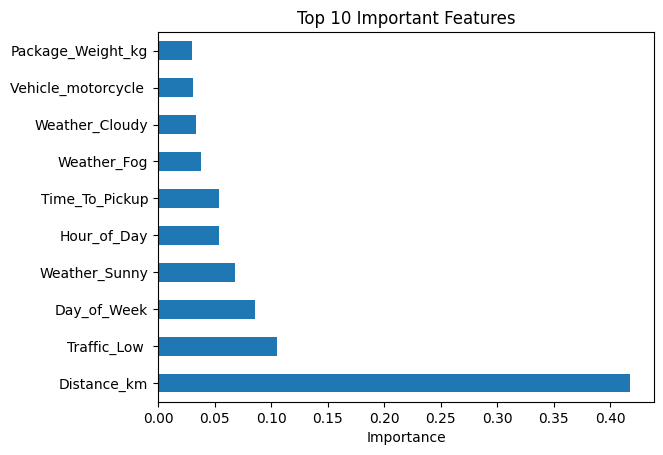

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature names from the preprocessor
cat_features = model_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(['Traffic', 'Weather', 'Vehicle'])

num_features = ['Time_To_Pickup', 'Distance_km', 'Package_Weight_kg', 'Hour_of_Day', 'Day_of_Week', 'Is_Weekend']
all_features = list(cat_features) + num_features

# Access feature importances from the regressor
feat_importances = pd.Series(
    model_pipeline.named_steps['regressor'].feature_importances_,
    index=all_features
)

# Plot top 10
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.show()


In [56]:
import joblib

# Save the trained model to a file
joblib.dump(model_pipeline, 'delivery_time_predictor.pkl')
print("✅ Model saved as 'delivery_time_predictor.pkl'")

✅ Model saved as 'delivery_time_predictor.pkl'


In [57]:
!pip install streamlit
!pip install pyngrok

In [58]:

import streamlit as st

st.title("Hello, Streamlit!")
st.write("This is a simple Streamlit app running in Colab.")

2025-04-17 07:36:24.234 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 07:36:24.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 07:36:24.237 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 07:36:24.238 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 07:36:24.241 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 07:36:24.242 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [59]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [43]:
import joblib
model = joblib.load("delivery_time_predictor.pkl")

In [44]:
from pyngrok import ngrok

# Replace this with your actual ngrok auth token
ngrok.set_auth_token("2vSsIscB6UBWW5LPT5abIpV7O9R_2eQVtvynwUijN4VQ4m6ET")


In [47]:
public_url = ngrok.connect("8501")
print(f"Streamlit app is available at: {public_url}")


Streamlit app is available at: NgrokTunnel: "https://ea2b-34-75-231-211.ngrok-free.app" -> "http://localhost:8501"


In [48]:
!streamlit run app.py &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.75.231.211:8501



────────────────────────── Traceback (most recent call last) ───────────────────────────
  /usr/local/lib/python3.11/dist-packages/streamlit/runtime/scriptrunner/exec_code.py:  
  121 in exec_func_with_error_handling                                                  
                                                                                        
  /usr/local/lib/python3.11/dist-packages/streamlit/runtime/scriptrunner/script_runner  
  .py:640 in code_to_exec                                                               
                                                                                        
  /content/app.py:43 in <module>                                                        
                                                                                        
    40                                                                                  
    41 # Prediction                                                                     
    42 if st.button("